In [1]:
import ast
import re
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
import pyranges as pr

# HH and TnG peak frequency comparison

### Loading ChIP-seq peaks

In [2]:
foxp3_peak_sequences = pd.read_csv("figure5_files/foxp3_chipseq_peak_sequences_with_peak_id.csv")
foxp3_chipseq_tng_loci = pd.read_csv("figure5_files/foxp3_chipseq_tng_loci.csv")

In [3]:
foxp3_chipseq_tng_loci.head()

,chr,TnG_start,TnG_end,strand
0,chr1,3241813,3241839,-
1,chr1,3768338,3768358,-
2,chr1,4084282,4084297,-
3,chr1,4084304,4084331,-
4,chr1,4949358,4949384,+


### Assign unique peak ID to each ChIP-seq peak

In [4]:
def assign_matching_chip_peaks(peak_df, tng_df):
    """
    Matches ChIP/ATAC peaks to TnG loci using overlap and adds list of peak IDs to each TnG row.
    """
    peak_df = peak_df.copy()
    peak_df['chr'] = 'chr' + peak_df['chr'].astype(str)

    chip_pr = pr.PyRanges(peak_df.rename(columns={"chr": "Chromosome", "start": "Start", "end": "End"}))
    tng_pr = pr.PyRanges(tng_df.rename(columns={"chr": "Chromosome", "TnG_start": "Start", "TnG_end": "End"}))

    overlap = tng_pr.join(chip_pr).df

    # Map overlapping peaks to TnG loci
    peak_map = defaultdict(list)
    for _, row in overlap.iterrows():
        key = (row['Chromosome'], row['Start'], row['End'])
        peak_map[key].append(row['peak'])

    def get_peaks(row):
        key = (row['chr'], row['TnG_start'], row['TnG_end'])
        return peak_map.get(key, [])

    tng_df = tng_df.copy()
    tng_df['peaks'] = tng_df.apply(get_peaks, axis=1)
    return tng_df


In [5]:
# Run ChIP-seq code, load ATAC (would take too long)
foxp3_chipseq_tng_loci = assign_matching_chip_peaks(foxp3_peak_sequences, foxp3_chipseq_tng_loci)
atac_tng_loci = pd.read_csv('figure5_files/atac_tng_loci.csv')

In [6]:
foxp3_chipseq_tng_loci.head()

,chr,TnG_start,TnG_end,strand,peaks
0,chr1,3241813,3241839,-,[0]
1,chr1,3768338,3768358,-,[2]
2,chr1,4084282,4084297,-,[3]
3,chr1,4084304,4084331,-,[3]
4,chr1,4949358,4949384,+,[8]


In [7]:
def count_unique_chip_peaks(df, column='peaks'):
    """
    Counts the number of unique peak IDs from a column of lists.
    """
    all_peaks = df[column].explode().dropna()
    return len(set(all_peaks))

print(f"Number of unique FoxP3 ChIP peaks: {count_unique_chip_peaks(foxp3_chipseq_tng_loci)}")
print(f"Number of unique ATAC peaks: {count_unique_chip_peaks(atac_tng_loci)}")

Number of unique FoxP3 ChIP peaks: 9744
Number of unique ATAC peaks: 87926


### Example of building reg-ex motifs and searching for them

In [8]:
# Top 10 enriched motif sequences in forward and reverse-complement orientation
motifs_forward = ['NNAAACA', 'NAAACAN', 'NNCAACA', 'NCAACAN', 'ATGCGNN', 'GATGCNN', 'ATGCANN', 'AATGCNN', 'NATGCAN', 'ATGCNNC']
motifs_reverse = ['TGTTTNN', 'NTGTTTN', 'TGTTGNN', 'NTGTTGN', 'NNCGCAT', 'NNGCATC', 'NNTGCAT', 'NNGCATT', 'NTGCATN', 'GNNGCAT']

motif_combos_TH = [(f1, f2) for f1 in motifs_forward for f2 in motifs_forward]
motif_combos_HT = [(r1, r2) for r1 in motifs_reverse for r2 in motifs_reverse]

# Pairwise motif combinations combinations for Head-to-Head (H-H) orientation
motif_combos_HH = [(r, f) for r in motifs_reverse for f in motifs_forward]

In [9]:
# Convert peak DataFrame into a list of tuples: (chrom, start, end, sequence)
chipseq_sequences = list(foxp3_peak_sequences.itertuples(index=False, name=None))

def generate_regex_motifs(motif_pairs):
    """
    Convert motif pairs into regex patterns with a fixed 4bp spacer between motifs.
    """
    return [
        f"{f.replace('N', '[ATGC]')}[ATGC]{{4}}{r.replace('N', '[ATGC]')}"
        for f, r in motif_pairs
    ]

def build_motif_regex_dict():
    """
    Generate a dictionary of regex motif patterns by orientation:
    """
    return {
        'HH': {i: p for i, p in enumerate(generate_regex_motifs(motif_combos_HH))},
    }

# Build all regex motif patterns
motif_regex_by_orientation = build_motif_regex_dict()

In [10]:
# Display 3 example regex motifs from each orientation
for orientation, motifs in motif_regex_by_orientation.items():
    print(f"Examples from orientation '{orientation}':")
    for i in list(motifs.keys())[:3]:
        print(f"  {i}: {motifs[i]}")
    print()

Examples from orientation 'HH':
  0: TGTTT[ATGC][ATGC][ATGC]{4}[ATGC][ATGC]AAACA
  1: TGTTT[ATGC][ATGC][ATGC]{4}[ATGC]AAACA[ATGC]
  2: TGTTT[ATGC][ATGC][ATGC]{4}[ATGC][ATGC]CAACA



In [11]:
def match_example_pattern(sequences, pattern_label, pattern):
    matches_list = []
    regex = re.compile(pattern)

    for chrom, peak_start, peak_end, sequence, peak in sequences:
        if sequence == "Sequence not found" or pd.isna(sequence):
            continue
        for match in regex.finditer(sequence):
            match_start = peak_start + match.start() - 1 # minus 1 for indexing
            match_end = peak_start + match.end()
            matches_list.append((chrom, match_start, match_end, peak))

    df_matches = pd.DataFrame(matches_list, columns=['chr', 'start', 'end', 'peak'])
    return df_matches

# Example usage
example_label = "Example_Motif"
example_pattern = "TGTTT[ATGC]{2}[ATGC]{4}[ATGC]{2}AAACA"
df_example_matches = match_example_pattern(chipseq_sequences, example_label, example_pattern)

# Print top 5 matches
df_example_matches.head()

,chr,start,end,peak
0,1,16029469,16029488,53
1,1,33883181,33883200,103
2,1,36267408,36267427,122
3,1,40618125,40618144,203
4,1,52052815,52052834,270


### Load ChIP-seq and ATAC-seq peaks with their IDs

In [12]:
# Load full set of motif-pair loci in Head-to-Head (H-H) orientation for FoxP3 ChIP-seq
chipseq_peaks_hh = pd.read_csv("figure5_files/head_to_head_foxp3_chipseq.csv")
chipseq_peaks_hh.head()

,chr,start,end,peaks
0,chr1,6417656,6417674,[17]
1,chr1,9798723,9798741,[27]
2,chr1,13371997,13372015,[40]
3,chr1,13593378,13593397,[44]
4,chr1,16029470,16029488,[53]


In [13]:
# Convert peak strings to lists
chipseq_peaks_hh['peaks'] = chipseq_peaks_hh['peaks'].apply(ast.literal_eval)

# Get set of all FoxP3 peaks that intersect TnG loci
tng_peak_set_foxp3 = set().union(*foxp3_chipseq_tng_loci['peaks'])

# Add boolean flag for overlap with TnG regions
chipseq_peaks_hh['overlaps_with_tng'] = chipseq_peaks_hh['peaks'].apply(
    lambda peak_list: any(p in tng_peak_set_foxp3 for p in peak_list)
)

In [14]:
# Load full set of motif-pair loci in H-H orientation for ATAC-seq
atac_peaks_hh = pd.read_csv("figure5_files/head_to_head_atac.csv")
atac_peaks_hh.head()

,chr,start,end,peaks
0,chr1,4401780,4401798,[47]
1,chr1,4432779,4432798,[62]
2,chr1,4527520,4527538,[88]
3,chr1,5101085,5101103,[205]
4,chr1,6461642,6461660,[306]


### Identify which peaks contain both a HH and TnG

In [15]:
# Convert stringified lists to proper Python lists
atac_peaks_hh['peaks'] = atac_peaks_hh['peaks'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
atac_tng_loci['peaks'] = atac_tng_loci['peaks'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Get set of ATAC peaks that intersect TnG loci
tng_peak_set_atac = set().union(*atac_tng_loci['peaks'])

# Add boolean flag for overlap with TnG regions
atac_peaks_hh['overlaps_with_tng'] = atac_peaks_hh['peaks'].apply(
    lambda peak_list: any(p in tng_peak_set_atac for p in peak_list)
)

In [16]:
# Count all unique ChIP-seq peaks found in H-H motif-pair matches
print(f"Number of unique H-H FoxP3 ChIP-seq peaks: {count_unique_chip_peaks(chipseq_peaks_hh)}")

# Count all unique ATAC-seq peaks found in H-H motif-pair matches
print(f"Number of unique H-H ATAC-seq peaks: {count_unique_chip_peaks(atac_peaks_hh)}")

Number of unique H-H FoxP3 ChIP-seq peaks: 1454
Number of unique H-H ATAC-seq peaks: 10143


In [17]:
# Print subset the ChIP-seq H-H peaks that overlap with TnG loci
chipseq_peaks_hh_tng = chipseq_peaks_hh[chipseq_peaks_hh['overlaps_with_tng']].copy()
print(f"Number of unique FoxP3 ChIP-seq peaks with H-H + TnG overlap: {count_unique_chip_peaks(chipseq_peaks_hh_tng)}")

# Print subset ATAC-seq H-H peaks that overlap TnG, and count unique peaks
atac_peaks_hh_tng = atac_peaks_hh[atac_peaks_hh['overlaps_with_tng']].copy()
print(f"Number of unique ATAC peaks with H-H + TnG overlap: {count_unique_chip_peaks(atac_peaks_hh_tng)}")

Number of unique FoxP3 ChIP-seq peaks with H-H + TnG overlap: 1200
Number of unique ATAC peaks with H-H + TnG overlap: 2604


# HH and TnG distance comparison

In [18]:
# Load distance-to-nearest TnG data for H-H motif pairs
foxp3_hh_tng_distances = pd.read_csv('figure5_files/hh_tng_distance_chip.csv')
atac_hh_tng_distances = pd.read_csv('figure5_files/hh_tng_distance_fp3_free_ocr.csv')

In [19]:
foxp3_hh_tng_distances.head()

,chr,h_h_start,h_h_end,closest_TnG_start,closest_TnG_end,tng_alignment,distance_to_closest_TnG
0,chr1,6417656,6417674,6417733,6417756,1,59
1,chr1,9798723,9798741,9798859,9798902,1,118
2,chr1,13371997,13372015,13371878,13371920,0,-77
3,chr1,13593378,13593397,13593430,13593453,0,33
4,chr1,16029470,16029488,16029459,16029505,1,0


In [20]:
# Keep only motif pairs that overlap exactly with a TnG repeat
foxp3_hh_overlapping = foxp3_hh_tng_distances[foxp3_hh_tng_distances['distance_to_closest_TnG'] == 0]
atac_hh_overlapping = atac_hh_tng_distances[atac_hh_tng_distances['distance_to_closest_TnG'] == 0]

In [21]:
foxp3_hh_overlapping.head()

,chr,h_h_start,h_h_end,closest_TnG_start,closest_TnG_end,tng_alignment,distance_to_closest_TnG
4,chr1,16029470,16029488,16029459,16029505,1,0
6,chr1,33883182,33883200,33883168,33883188,1,0
7,chr1,34545778,34545796,34545766,34545782,1,0
9,chr1,36267409,36267427,36267385,36267424,1,0
15,chr1,39714299,39714318,39714285,39714324,1,0


In [22]:
# Separate motif pairs by whether their orientation matches TnG compatibility
foxp3_hh_tng_compatible = foxp3_hh_overlapping[foxp3_hh_overlapping['tng_alignment'] == 1]
foxp3_hh_tng_noncompatible = foxp3_hh_overlapping[foxp3_hh_overlapping['tng_alignment'] != 1]

atac_hh_tng_compatible = atac_hh_overlapping[atac_hh_overlapping['tng_alignment'] == 1]
atac_hh_tng_noncompatible = atac_hh_overlapping[atac_hh_overlapping['tng_alignment'] != 1]

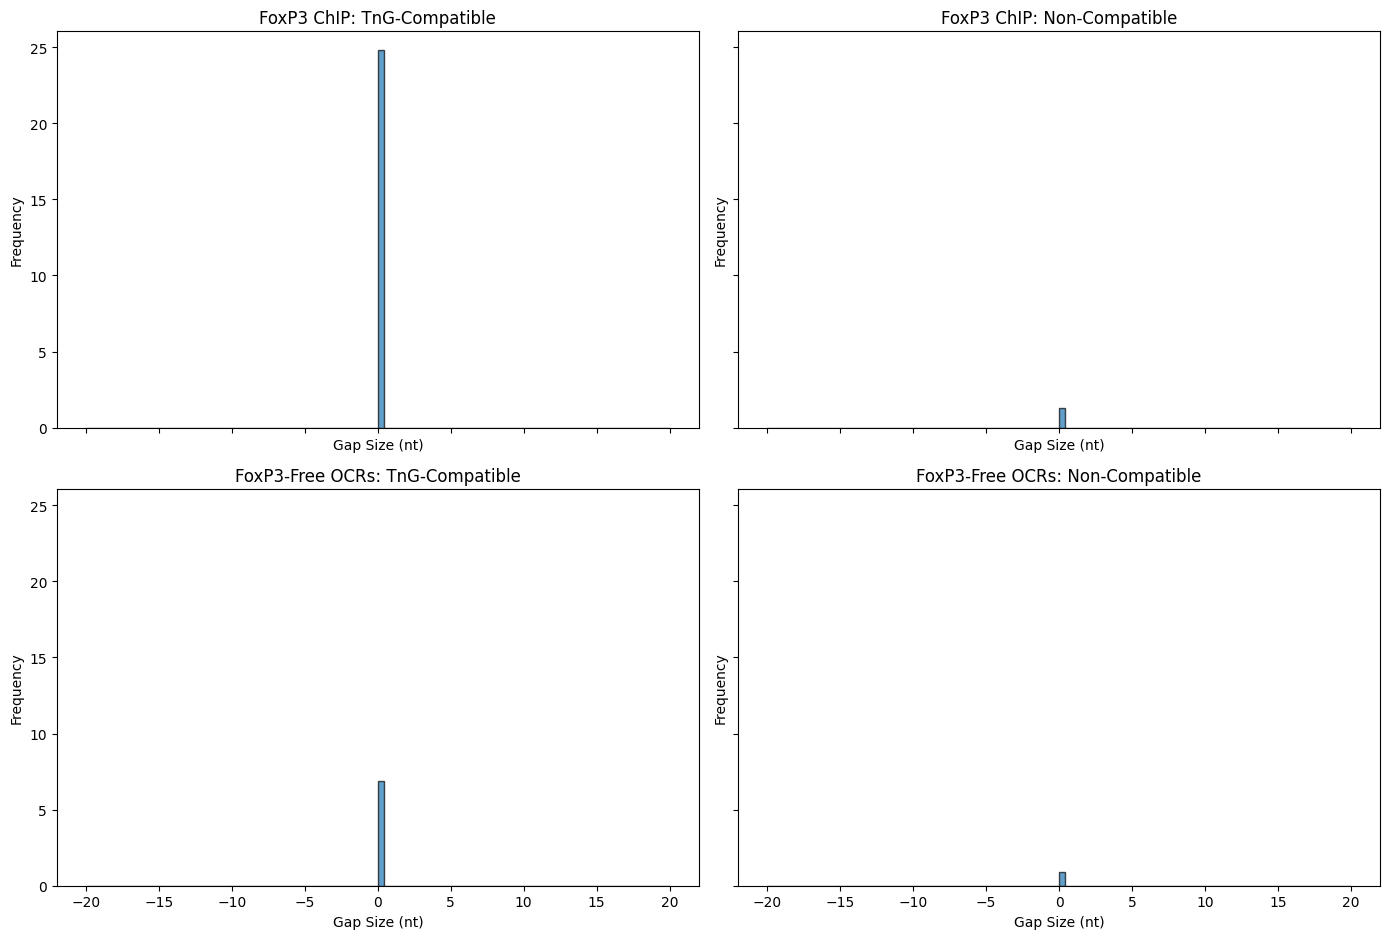

In [23]:
# Plotting layout: 2 rows (ChIP vs ATAC), 2 cols (compatible vs non-compatible)
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

# Histogram settings
x_min, x_max = -20, 20
bins = 100
range_vals = (x_min, x_max)

def plot_percentage_histogram(ax, data, total, title):
    """
    Plot a histogram of motif-to-TnG distances as percentage of total motifs.
    """
    ax.hist(
        data['distance_to_closest_TnG'],
        bins=bins,
        range=range_vals,
        weights=[100 / total] * len(data),
        edgecolor='black',
        alpha=0.7
    )
    ax.set_title(title)
    ax.set_xlabel('Gap Size (nt)')
    ax.set_ylabel('Frequency')

# Row 1: FoxP3 ChIP-seq
plot_percentage_histogram(axes[0, 0], foxp3_hh_tng_compatible, len(foxp3_hh_tng_distances), 'FoxP3 ChIP: TnG-Compatible')
plot_percentage_histogram(axes[0, 1], foxp3_hh_tng_noncompatible, len(foxp3_hh_tng_distances), 'FoxP3 ChIP: Non-Compatible')

# Row 2: ATAC OCRs (FoxP3-free regions)
plot_percentage_histogram(axes[1, 0], atac_hh_tng_compatible, len(atac_hh_tng_distances), 'FoxP3-Free OCRs: TnG-Compatible')
plot_percentage_histogram(axes[1, 1], atac_hh_tng_noncompatible, len(atac_hh_tng_distances), 'FoxP3-Free OCRs: Non-Compatible')

# Plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# TnG Length Distribution Comparison

In [24]:
# TnG motifs that overlap FoxP3 Head-to-Head motif pairs and are in the correct alignment
foxp3_hh_tng_distances = pd.read_csv('figure5_files/hh_tng_distance_chip.csv')
tng_close_to_hh = foxp3_hh_tng_distances[
    (foxp3_hh_tng_distances['distance_to_closest_TnG'] == 0) &
    (foxp3_hh_tng_distances['tng_alignment'] == 1)
].copy()

# TnG motifs >1kb away from any H-H motif pair (background set)
tng_far_from_hh = pd.read_csv('figure5_files/tng_far_from_hh.csv')

# Calculate lengths of both groups
tng_close_to_hh['length'] = tng_close_to_hh['closest_TnG_end'] - tng_close_to_hh['closest_TnG_start']
tng_far_from_hh['length'] = tng_far_from_hh['TnG_end'] - tng_far_from_hh['TnG_start']

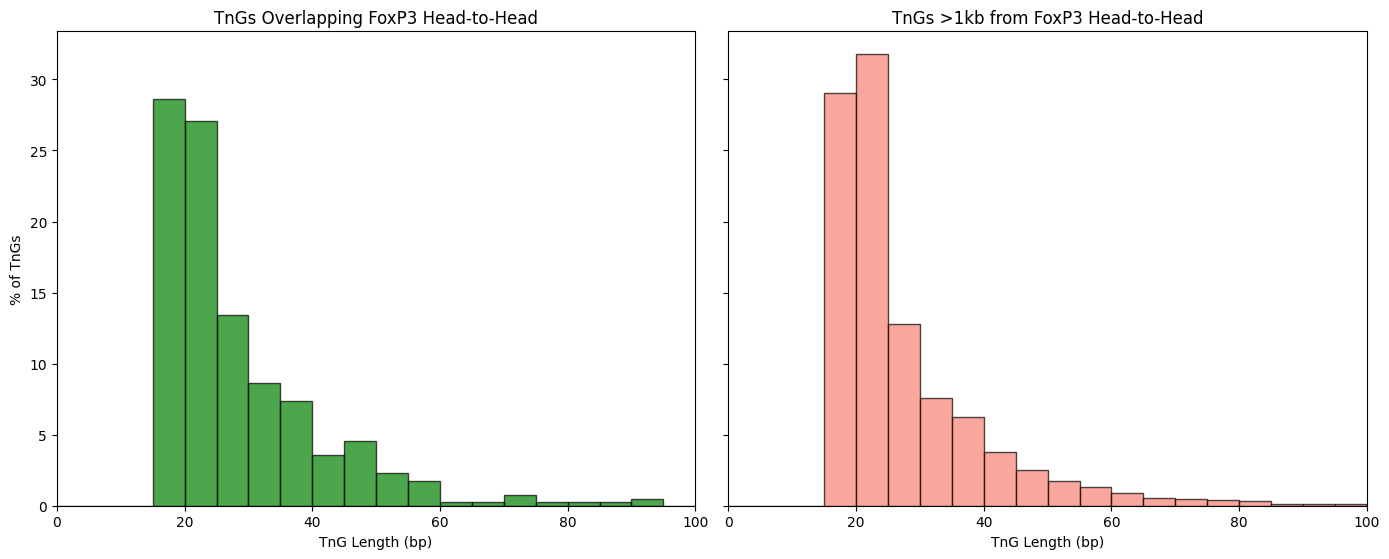

In [25]:
# Plot length distributions of TnGs close and far from HH motifs

bins = range(0, 101, 5)  # 0 to 100 bp, in 5bp bins
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Histogram: TnGs Overlapping FoxP3 H-H
axs[0].hist(
    tng_close_to_hh['length'],
    bins=bins,
    weights=[100 / len(tng_close_to_hh)] * len(tng_close_to_hh),
    alpha=0.7,
    color='green',
    edgecolor='black'
)
axs[0].set_title('TnGs Overlapping FoxP3 Head-to-Head')
axs[0].set_xlabel('TnG Length (bp)')
axs[0].set_ylabel('% of TnGs')
axs[0].set_xlim(0, 100)

# Histogram: TnGs Far from FoxP3 H-H
axs[1].hist(
    tng_far_from_hh['length'],
    bins=bins,
    weights=[100 / len(tng_far_from_hh)] * len(tng_far_from_hh),
    alpha=0.7,
    color='salmon',
    edgecolor='black'
)
axs[1].set_title('TnGs >1kb from FoxP3 Head-to-Head')
axs[1].set_xlabel('TnG Length (bp)')
axs[1].set_xlim(0, 100)

# Plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()